# Statistiques Exploratoires

In [ ]:
# Import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from collections import Counter
from wordcloud import WordCloud
import re
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
nltk.download('stopwords')

nltk.download('punkt')
from nltk.tokenize import word_tokenize


## ISOT

In [ ]:
# Loading dataset
df_true = pd.read_csv('data/isot/raw/True.csv')
df_fake = pd.read_csv('data/isot/raw/Fake.csv')

In [ ]:
df_true.shape, df_fake.shape

In [ ]:
df_fake.sample(5)

In [ ]:
df_true.sample(5)

In [ ]:
def remove_intro_and_store_city_source(df):
    # Appliquer la fonction sur chaque ligne de la dataframe
    def process_row(row):
        # Extraire la portion supprimée (avant le premier tiret suivi d'un espace)
        intro = re.match(r'^.*?-\s+', row['text'])
        if intro:
            # Retirer l'intro du texte
            row['text'] = re.sub(r'^.*?-\s+', '', row['text'])
            
            # Extraction de la ville et de la source à partir de la portion supprimée
            match = re.match(r'([A-Za-z\s]+)\s\(([^)]+)\)\s-\s', intro.group(0))
            if match:
                # Extraire la ville et la source
                row['city'] = match.group(1).strip()
                row['source_name'] = match.group(2).strip()
            else:
                row['city'] = np.nan
                row['source_name'] = np.nan
        else:
            # Si aucune intro n'est trouvée, ne rien changer
            row['city'] = ''
            row['source_name'] = ''
        
        return row
    
    # Appliquer cette fonction à chaque ligne du DataFrame
    df = df.apply(process_row, axis=1)
    return df



In [ ]:
df = remove_intro_and_store_city_source(df_true)


In [ ]:
df

# STAT Générale

In [ ]:
# Taille du dataset
print("Dataset articles : TRUE")
print(f"Nombre total d'articles : {len(df)}")

# Longueur des textes et titres
df['text_length'] = df['text'].apply(lambda x: len(str(x)))
df['text_wordcount'] = df['text'].apply(lambda x: len(str(x).split()))
df['title_wordcount'] = df['title'].apply(lambda x: len(str(x).split()))

# Stats descriptives
print(df[['text_wordcount', 'title_wordcount']].describe())


In [ ]:
# Histogramme des longueurs de texte
plt.figure(figsize=(10,5))
sns.histplot(df['text_wordcount'], bins=50, kde=True)
plt.title("Distribution du nombre de mots dans les articles")
plt.xlabel("Nombre de mots")
plt.ylabel("Fréquence")
plt.show()


# Catégorie / Topic

In [ ]:
# Top sujets
print(df['subject'].value_counts())
df['subject'].value_counts().plot(kind='bar', title="Distribution des sujets")

# Top villes et sources
print(df['city'].value_counts().head())
print(df['source_name'].value_counts().head())


In [ ]:
df['date'] = pd.to_datetime(df['date'], errors='coerce')

# Nombre d’articles par année
df['year'] = df['date'].dt.year
df['year'].value_counts().sort_index().plot(kind='bar', title="Nombre d'articles par année")

# Analyse du contenu 

In [ ]:
nltk.data.path.append('/tmp/nltk_data')

# Ensuite importer
from nltk.corpus import stopwords
stop_words = ENGLISH_STOP_WORDS

# Fonction pour extraire les mots
def get_top_words(texts, n=20):
    words = []
    for text in texts:
        tokens = re.findall(r'\b\w+\b', str(text).lower())
        words.extend([word for word in tokens if word.isalpha() and word not in stop_words])
    return Counter(words).most_common(n)

top_words = get_top_words(df['text'])
print("Top mots :", top_words)


In [ ]:
import nltk
from nltk.corpus import stopwords
from collections import Counter
import re

# Télécharger les stopwords si ce n’est pas fait
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

# Liste personnalisée de mots peu informatifs
custom_stopwords = set([
    'said', 's', 'u', 'us', 'would', 'also', 'one', 'two', 'new', 'could',
    'like', 'told', 'get', 'say', 'mr', 'mrs', 'ms', 'reuters', 'reported',
    'according', 'news', 'even', 'make', 'much', 'many'
])
stop_words.update(custom_stopwords)

# Fonction pour extraire les mots fréquents
def get_top_words(texts, n=20):
    words = []
    for text in texts:
        tokens = re.findall(r'\b\w+\b', str(text).lower())
        words.extend([word for word in tokens if word.isalpha() and word not in stop_words and len(word) > 2])
    return Counter(words).most_common(n)

# Utilisation
top_words = get_top_words(df['text'])
print("🔠 Top mots :", top_words)


# Nuage de mots

In [ ]:
text_corpus = ' '.join(df['text'].dropna().astype(str))
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text_corpus)

plt.figure(figsize=(15, 7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Word Cloud des textes")
plt.show()


# Croisements

In [ ]:
# Nombre d’articles par sujet et source
pivot = pd.pivot_table(df, index='subject', columns='source_name', aggfunc='size', fill_value=0)
print(pivot.head())

# Longueur moyenne du texte par sujet
print(df.groupby('subject')['text_wordcount'].mean())


# Données manquantes

In [ ]:
# Valeurs manquantes
print(df.isnull().sum())

# Pourcentage de manquant
print((df.isnull().mean() * 100).round(2))


## Kaggle

In [3]:
df = pd.read_csv('data/kaggle/raw/fake_or_real_news.csv')

In [8]:
df.sample(5)

,Unnamed: 0,title,text,label
3859,598,California governor signs bill to automaticall...,Federal laws already allow people across the c...,REAL
2088,4590,"Trump Gives Victory Speech, Liberals Rediscove...",President-Elect Donald Trump preached national...,REAL
3381,5461,Assange: Clinton Campaign Tried To Hack WikiLeaks,"Edmondo Burr in News , World // 0 Comments J...",FAKE
5348,7536,Internationally-backed Libyan forces attack Da...,Fighters loyal to Libya’s UN-backed government...,FAKE
498,693,A report said Trump's donations to vets might ...,Donald Trump is adamant that he raised more th...,REAL


In [10]:
# Taille du dataset
print("Dataset articles : TRUE")
print(f"Nombre total d'articles : {len(df)}")

# Longueur des textes et titres
df['text_length'] = df['text'].apply(lambda x: len(str(x)))
df['text_wordcount'] = df['text'].apply(lambda x: len(str(x).split()))
df['title_wordcount'] = df['title'].apply(lambda x: len(str(x).split()))

# Stats descriptives
print(df[['text_wordcount', 'title_wordcount']].describe())


Dataset articles : TRUE
Nombre total d'articles : 6335
       text_wordcount  title_wordcount
count     6335.000000      6335.000000
mean       776.300710        10.496448
std        854.333358         3.985165
min          0.000000         1.000000
25%        289.000000         8.000000
50%        597.000000        10.000000
75%       1024.000000        13.000000
max      20891.000000        53.000000


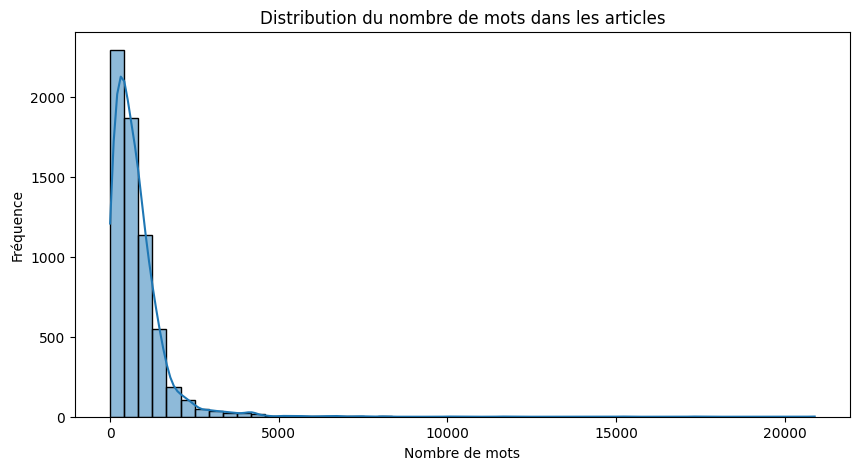

In [11]:
# Histogramme des longueurs de texte
plt.figure(figsize=(10,5))
sns.histplot(df['text_wordcount'], bins=50, kde=True)
plt.title("Distribution du nombre de mots dans les articles")
plt.xlabel("Nombre de mots")
plt.ylabel("Fréquence")
plt.show()


# Analyse du contenu 

In [14]:
nltk.data.path.append('/tmp/nltk_data')

# Ensuite importer
from nltk.corpus import stopwords
stop_words = ENGLISH_STOP_WORDS

# Fonction pour extraire les mots
def get_top_words(texts, n=20):
    words = []
    for text in texts:
        tokens = re.findall(r'\b\w+\b', str(text).lower())
        words.extend([word for word in tokens if word.isalpha() and word not in stop_words])
    return Counter(words).most_common(n)

top_words = get_top_words(df['text'])
print("Top mots :", top_words)


Top mots : [('s', 62114), ('trump', 22437), ('said', 21212), ('clinton', 17503), ('t', 16386), ('people', 11750), ('new', 9331), ('state', 9211), ('president', 8844), ('obama', 8234), ('campaign', 7719), ('just', 7448), ('like', 7248), ('hillary', 7213), ('time', 6959), ('states', 6236), ('republican', 5936), ('party', 5878), ('u', 5790), ('election', 5493)]


In [15]:
import nltk
from nltk.corpus import stopwords
from collections import Counter
import re

# Télécharger les stopwords si ce n’est pas fait
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

# Liste personnalisée de mots peu informatifs
custom_stopwords = set([
    'said', 's', 'u', 'us', 'would', 'also', 'one', 'two', 'new', 'could',
    'like', 'told', 'get', 'say', 'mr', 'mrs', 'ms', 'reuters', 'reported',
    'according', 'news', 'even', 'make', 'much', 'many'
])
stop_words.update(custom_stopwords)

# Fonction pour extraire les mots fréquents
def get_top_words(texts, n=20):
    words = []
    for text in texts:
        tokens = re.findall(r'\b\w+\b', str(text).lower())
        words.extend([word for word in tokens if word.isalpha() and word not in stop_words and len(word) > 2])
    return Counter(words).most_common(n)

# Utilisation
top_words = get_top_words(df['text'])
print("🔠 Top mots :", top_words)


[nltk_data] Error loading stopwords: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     unable to get local issuer certificate (_ssl.c:1000)>


LookupError: 
**********************************************************************
  Resource [93mstopwords[0m not found.
  Please use the NLTK Downloader to obtain the resource:

  [31m>>> import nltk
  >>> nltk.download('stopwords')
  [0m
  For more information see: https://www.nltk.org/data.html

  Attempted to load [93mcorpora/stopwords[0m

  Searched in:
    - '/Users/imrane/nltk_data'
    - '/Library/Frameworks/Python.framework/Versions/3.12/nltk_data'
    - '/Library/Frameworks/Python.framework/Versions/3.12/share/nltk_data'
    - '/Library/Frameworks/Python.framework/Versions/3.12/lib/nltk_data'
    - '/usr/share/nltk_data'
    - '/usr/local/share/nltk_data'
    - '/usr/lib/nltk_data'
    - '/usr/local/lib/nltk_data'
    - '/tmp/nltk_data'
**********************************************************************


# Nuage de mots

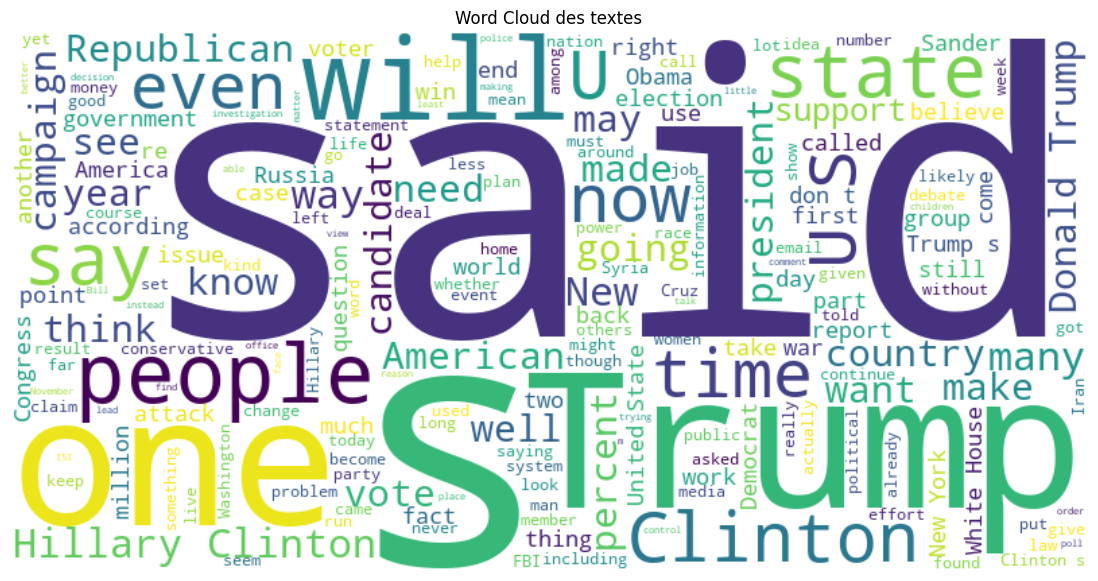

In [16]:
text_corpus = ' '.join(df['text'].dropna().astype(str))
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text_corpus)

plt.figure(figsize=(15, 7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Word Cloud des textes")
plt.show()


# Données manquantes

In [17]:
# Valeurs manquantes
print(df.isnull().sum())

# Pourcentage de manquant
print((df.isnull().mean() * 100).round(2))


Unnamed: 0         0
title              0
text               0
label              0
text_length        0
text_wordcount     0
title_wordcount    0
dtype: int64
Unnamed: 0         0.0
title              0.0
text               0.0
label              0.0
text_length        0.0
text_wordcount     0.0
title_wordcount    0.0
dtype: float64
